In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import cv2
import keras.backend as K
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
from IPython.display import clear_output

Using TensorFlow backend.


In [10]:
def normalize(x):
    x = (x - x.min())/(x.max() - x.min() + 1e-8)
    return x

In [11]:
def get_blob(size):
    blobs = np.zeros((size, 64, 64, 1))
    for i in range(size):
        blob = np.zeros((64, 64))
        idx_x = np.random.randint(10, 54)
        idx_y = np.random.randint(10, 54)
        blob[idx_x, idx_y] = 1
#         blur_radius = np.random.randint(0, 10) * 2 + 11
        blur_radius = 21
        blur = cv2.GaussianBlur(blob,(blur_radius, blur_radius),0)
        blobs[i, :, :, 0] = normalize(blur)
    return blobs

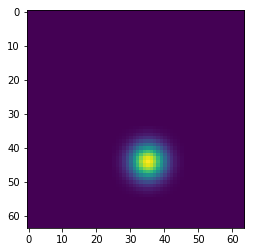

In [12]:
blob = get_blob(1)
plt.imshow(np.squeeze(blob))

In [49]:
num_train = 10000
batch_size = 128
latent_dim = 6
epochs = 100
learning_rate = 1e-4
beta = 1
C_multiplier = 0.0015
C_limit = 25.0

In [55]:
# reset graph
tf.reset_default_graph()

he_init = tf.contrib.layers.variance_scaling_initializer()
kernel_init = he_init
act_fn = tf.nn.relu

# network architecture
with tf.name_scope('encoder') as scope:
    num_filter = 16
    x0 = tf.placeholder(tf.float32, [None, image_size, image_size, 1])
    x = tf.layers.conv2d(inputs = x0, 
                         filters = num_filter, 
                         kernel_size = (3, 3),
                         strides = (2, 2), 
                         padding = 'same',
                         kernel_initializer = kernel_init, 
                         activation = act_fn)
    for i in range(3):
        num_filter = num_filter * 2
        x = tf.layers.conv2d(inputs = x, 
                             filters = num_filter, 
                             kernel_size = (3, 3),
                             strides = (2, 2), 
                             padding = 'same',
                             kernel_initializer = kernel_init, 
                             activation = act_fn)
    shape = K.int_shape(x)
    x = tf.contrib.layers.flatten(x)
    x = tf.layers.dense(x, 256, activation = act_fn)
    
with tf.name_scope('latent') as scope:
    z_mean = tf.layers.dense(x, latent_dim, name = 'z_mean')
    z_log_var = tf.layers.dense(x, latent_dim, name = 'z_log_var')
    dist = tf.distributions.Normal(0., 1.)
    epsilon = dist.sample()
    z_sample = z_mean + tf.exp(0.5 * z_log_var) * epsilon

with tf.name_scope('decoder') as scope:
    x = tf.layers.dense(z_sample, 256, activation = act_fn)
    x = tf.layers.dense(x, shape[1]*shape[2]*shape[3])
    x = tf.reshape(x, [-1, shape[1], shape[2], shape[3]])
    for i in range(3):
        x = tf.layers.conv2d_transpose(inputs = x,
                                       filters = num_filter, 
                                       kernel_size = (3, 3),
                                       strides = (2, 2), 
                                       padding = 'same',
                                       kernel_initializer = kernel_init, 
                                       activation = act_fn)
        num_filter = num_filter // 2
        
    x = tf.layers.conv2d_transpose(inputs = x,
                                   filters = 1, 
                                   kernel_size = (3, 3),
                                   strides = (2, 2), 
                                   padding = 'same',
                                   kernel_initializer = kernel_init)
    x_ = tf.nn.sigmoid(x, name = 'output')

# loss function
step = tf.placeholder(tf.float32)
C = tf.minimum(C_multiplier * step, C_limit)
reconstruction_loss = tf.losses.mean_squared_error(K.flatten(x0), K.flatten(x_))
reconstruction_loss *= image_size * image_size
kl_loss = -0.5 * tf.reduce_sum(
    1 + z_log_var 
    - tf.square(z_mean) 
    - tf.exp(z_log_var))
# loss = reconstruction_loss + beta * tf.abs(kl_loss - C)
loss = reconstruction_loss + beta * kl_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)
init_op = tf.global_variables_initializer()
saver = tf.train.Saver()

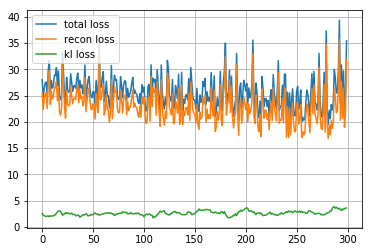

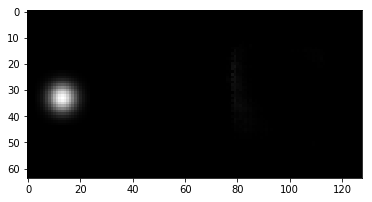

Epoch: 40, loss: 35.39917755126953


KeyboardInterrupt: 

In [56]:
step_value = 0.0
loss_hist = []
loss_recon_hist = []
loss_kl_hist = []
with tf.Session() as sess:
    sess.run(init_op)
    for epoch in range(epochs):
        for i in range(num_train//batch_size):
            train_imgs_sampled = get_blob(batch_size)
            _, loss_value, loss_recon, loss_kl, x_recon = sess.run([
                train_op, loss, reconstruction_loss, kl_loss, x_], feed_dict = {x0: train_imgs_sampled})
            loss_hist.append(loss_value)
            loss_recon_hist.append(loss_recon)
            loss_kl_hist.append(loss_kl)
        clear_output()
        if (len(loss_hist) < 300):
            plt.figure()
            plt.plot(loss_hist, label = 'total loss')
            plt.plot(loss_recon_hist, label = 'recon loss')
            plt.plot(loss_kl_hist, label = 'kl loss')
            plt.legend()
            plt.grid()
            plt.show()
        else:
            plt.figure()
            plt.plot(loss_hist[-300:], label = 'total loss')
            plt.plot(loss_recon_hist[-300:], label = 'recon loss')
            plt.plot(loss_kl_hist[-300:], label = 'kl loss')
            plt.legend()
            plt.grid()
            plt.show()
        
        plt.figure()
        to_show = np.zeros((64, 64*2))
        to_show[:, :64] = np.squeeze(train_imgs_sampled[0])
        to_show[:, 64:] = np.squeeze(x_recon[0])
        plt.imshow(to_show, cmap = 'gray')
        plt.show()
        print('Epoch: {}, loss: {}'.format(epoch, np.mean(loss_value)))
        print('==================================')
    save_path = saver.save(sess, "./dsprite_vae.ckpt")

INFO:tensorflow:Restoring parameters from ./dsprite_vae.ckpt


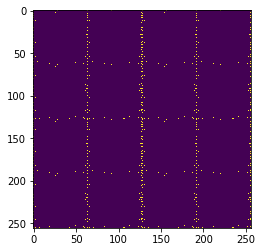

In [52]:
with tf.Session() as sess:
    saver.restore(sess, "./dsprite_vae.ckpt")
    seed_image = get_blob(16)
    to_show = np.zeros((64*4, 64*4))
    restored = sess.run(x_, feed_dict = {x0: seed_image})
    for i in range(4):
        for j in range(4):
            to_show[i*64:(i+1)*64, j*64:(j+1)*64] = restored[i*4+j, :, :, 0]
    plt.imshow(np.squeeze(to_show))

#     seed_image = get_blob(1)
#     plt.imshow(np.squeeze(seed_image))
#     plt.figure()
#     restored = sess.run(x_, feed_dict = {x0: seed_image})
#     plt.imshow(np.squeeze(restored))

INFO:tensorflow:Restoring parameters from ./dsprite_vae.ckpt


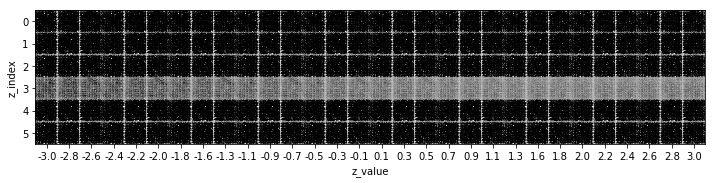

In [50]:
with tf.Session() as sess:
    saver.restore(sess, "./dsprite_vae.ckpt")
#     # Sample latents randomly
#     latents_sampled = sample_latent(size=10000)
#     # Select images
#     indices_sampled = latent_to_index(latents_sampled)
#     test_imgs_sampled = imgs[indices_sampled]
#     z_mean_values = sess.run(z_mean, feed_dict = {x0: test_imgs_sampled})

#     # 2D plot
#     plt.figure(figsize=(12, 12))
#     plt.scatter(z_mean_values[:, 0], z_mean_values[:, 1])
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
#     plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 64
    figure = np.zeros((digit_size * latent_dim, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-3, 3, n)
    grid_y = range(latent_dim)
    
#     seed_idx = np.random.randint(0, imgs.shape[0])
#     seed_image = imgs[seed_idx:seed_idx+1, :, :, 0:1]
    seed_image = get_blob(1)
    z_traversal = sess.run(z_mean, feed_dict = {x0: seed_image})

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_temp = np.copy(z_traversal)
            z_temp[0, i] = xi
            x_decoded = sess.run(x_, feed_dict = {z_sample: z_temp})
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(12, 12))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z_value")
    plt.ylabel("z_index")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

In [ ]:
plt.imshow(np.squeeze(seed_image))